<a href="https://colab.research.google.com/github/pedroafleite/crypto-risk-assessment/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install quandl

In [ ]:
import quandl as qd
import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt

In [ ]:
KEY = "zykxDXyzgxQSoKZM6y6v"
qd.ApiConfig.api_key = KEY
bitcoin = qd.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc[(bitcoin !=0).any(1)]

In [ ]:
bitcoin = bitcoin.reset_index()
bitcoin.head()

,Date,Value
0,2010-08-16,0.0769
1,2010-08-18,0.0688
2,2010-08-19,0.0667
3,2010-08-20,0.0700
4,2010-08-21,0.0664


In [ ]:
bitcoin["log_y"] = np.log(bitcoin["Value"])

In [ ]:
bitcoin = bitcoin.rename(columns={"Date": "ds", "log_y" : "y"})
bitcoin.head()

,ds,Value,y
0,2010-08-16,0.0769,-2.565249
1,2010-08-18,0.0688,-2.676552
2,2010-08-19,0.0667,-2.707550
3,2010-08-20,0.0700,-2.659260
4,2010-08-21,0.0664,-2.712058


In [ ]:
priors = [0.0015, 0.015]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(bitcoin)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2,                                                    freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [ ]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)

In [ ]:
output = output.set_index('Date')

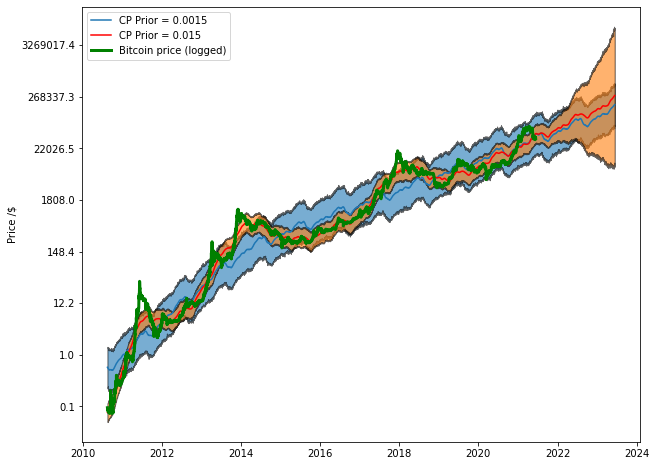

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(bitcoin.ds, bitcoin.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price /$")
plt.show()